In [70]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import json
import bs4
import re
from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')

In [2]:
# import bz2

# with bz2.open('../data_scraping/bills.json.bz2', 'r') as f:  
#     data = f.read()  
#     d = json.loads(data.decode("utf-8"))

In [3]:
# values = []

# for i in tqdm(list(d.values())):
#     dic = {}
#     soup = bs4.BeautifulSoup(i, 'html.parser')
#     content = soup.find('td', attrs = {'id':'content'}).text.strip()
#     try:
#         dic['congress'] = int(re.search('\d{2}(?=th Congress)',
#                                         content).group(0))
#         dic['type'] = re.search('(?<= Congress).+(?= Bill)', content).group(0)
#         bill_num = int(re.search('(?<=Bill No. )\d{1,}', content).group(0))
#         dic['bill_num'] = bill_num

        
#         dic['title'] = re.search(f'(?<=Bill No. {bill_num}).+(?=Filed)',
#                                  content).group(0)
#         dic['filed_on'] = re.search('(?<=Filed on ).+(?= by)',
#                                     content).group(0)
#         dic['filed_by'] = re.search('(?<=by ).+', content).group(0)
#         dic['introduced_by'] = re.search('(?<=Introduced by ).+',
#                                          content).group(0)
#         dic['long_title'] = re.search('(?<=Long title).+', content).group(0)
#         dic['scope'] = re.search('(?<=Scope).+', content).group(0)
#         dic['subjects'] = re.search('(?<=Subject\(s\)).+', content).group(0)
#         dic['primary_committee'] = re.search('(?<=Primary committee).+',
#                                              content).group(0)
#         dic['secondary_committee'] = re.search('(?<=Secondary committee).+',
#                                                content).group(0)
#     except:
#         pass
#     values.append(dic)

In [4]:
# df = pd.DataFrame(values)

In [5]:
df = pd.read_csv('bills.csv')

In [6]:
df.isna().sum()

Unnamed: 0                0
congress                  0
type                      0
bill_num                  0
title                     0
filed_on                  0
filed_by                  0
introduced_by           498
long_title              498
scope                   498
subjects                846
primary_committee       882
secondary_committee    5138
dtype: int64

In [7]:
df[df['introduced_by'].isna()].tail()

,Unnamed: 0,congress,type,bill_num,title,filed_on,filed_by,introduced_by,long_title,scope,subjects,primary_committee,secondary_committee
15444,15445,18,Senate,1541,AMENDING SECTION 3 OF RA 7797 (AN ACT TO LENGT...,"May 26, 2020","Sotto III, Vicente C., Villanueva, Joel, Tolen...",NaN,NaN,NaN,NaN,NaN,NaN
15465,15466,18,Senate,1562,RECRUITMENT QUOTA OF FEMALE PHILIPPINE NATIONA...,"May 28, 2020","Revilla Jr., Ramon Bong, De Lima, Leila M., De...",NaN,NaN,NaN,NaN,NaN,NaN
15466,15467,18,Senate,1563,"PNP, BFP, BJMP AND BUCOR HEIGHT EQUALITY ACT","May 28, 2020","Zubiri, Juan Miguel ""Migz"" F., Sotto III, Vice...",NaN,NaN,NaN,NaN,NaN,NaN
15467,15468,18,Senate,1564,BAYANIHAN TO RECOVER AS ONE ACT,"June 1, 2020","Marcos, Imee R., Angara, Sonny, Recto, Ralph G...",NaN,NaN,NaN,NaN,NaN,NaN
15485,15486,18,Senate,1582,SAFE PATHWAYS ACT,"June 3, 2020","Cayetano, Pia S., Tolentino, Francis ""Tol"" N.,...",NaN,NaN,NaN,NaN,NaN,NaN


Note: bill_num 1582 has a scope and long title but I think it is not really important.

In [8]:
df.dropna(subset=['filed_by'], inplace=True)

In [9]:
len(df)

15640

In [10]:
df['long_title'] = df['long_title'].fillna('')
df = df.fillna("N/A")

In [11]:
len(df)

15640

We will keep these bills and we can make Unknown as a catch all label for target variables. 

In [12]:
df.isna().sum()

Unnamed: 0             0
congress               0
type                   0
bill_num               0
title                  0
filed_on               0
filed_by               0
introduced_by          0
long_title             0
scope                  0
subjects               0
primary_committee      0
secondary_committee    0
dtype: int64

In [13]:
len(df)

15640

In [14]:
# df.to_pickle('bills.pkl', protocol=3)

## Preprocessing Pipeline

1. Data Cleaning
    1. Categorical Features
        1. Normalize names of categories 
        2. Convert strings of sequences of words to list of categories.
    2. Text Features
        1. Combine title and long title
        2. Natural Language Processing
            1. Removing of punctiations
            2. Removing stop words
            3. Lemmatization
    3. Convert dates to datetime columns

3. TF-IDF Vectorization Text Features for Clustering

In [15]:
df = pd.read_pickle('bills.pkl')

In [16]:
cols_used = ['congress', 'bill_num', 'title', 'long_title', 'filed_on',
             'filed_by', 'introduced_by',  'primary_committee', 'scope']
df = df[cols_used]

In [17]:
df.head()

,congress,bill_num,title,long_title,filed_on,filed_by,introduced_by,primary_committee,scope
0,13,1,SPECIAL MEASURES TO LOWER THE COST OF MEDICINE,AN ACT PRESCRIBING SPECIAL MEASURES TO LOWER...,"June 30, 2004","Flavier, Juan M., Angara, Edgardo J.",Senator FLAVIER;,Health and Demography,National
1,13,2,THE CONSTITUTIONAL CONVENTION ACT,AN ACT CALLING FOR A CONSTITUTIONAL CONVENTIO...,"June 30, 2004","Flavier, Juan M.",Senator FLAVIER;,"Constitutional Amendments, Revision of Codes a...",National
2,13,3,MAGNA CARTA OF PATIENT'S RIGHTS AND OBLIGATIONS,AN ACT DECLARING THE RIGHTS AND OBLIGATIONS O...,"June 30, 2004","Flavier, Juan M., Angara, Edgardo J.",Senator FLAVIER;,Health and Demography,National
3,13,4,HEALTH PROMOTION ACT OF 2004,AN ACT ESTABLISHING A NATIONAL HEALTH PROMOTI...,"June 30, 2004","Flavier, Juan M., Angara, Edgardo J.",Senator FLAVIER;,Government Corporations and Public Enterprises,National
4,13,5,INCREASING THE ALLOWABLE PERSONAL ADDITIONAL T...,AN ACT INCREASING THE ALLOWABLE PERSONAL ADDIT...,"June 30, 2004","Flavier, Juan M.",Senator FLAVIER;,Ways and Means,National


## Data Cleaning

In [18]:
df_clean = df.copy()

### Categorical Features

#### filed_by

In [19]:
# TODO: Still needs a lot of cleaning

df_clean['filed_by'] = df_clean['filed_by'].str.split('.')
df_clean['filed_by'].sample(5)

2750          [Angara, Edgardo J, ]
2058          [Biazon, Rodolfo G, ]
1504    [Defensor Santiago, Miriam]
5113    [Defensor Santiago, Miriam]
8435           [Enrile, Juan Ponce]
Name: filed_by, dtype: object

#### introduced_ by

In [20]:
# TODO: Still needs a lot of cleaning
# less effort because column might not be used later

df_clean['introduced_by'] = df_clean['introduced_by'].str.replace(
    'Senator |Senators |;', '')

df_clean['introduced_by'] = df_clean['introduced_by'].str.split(r'and|,')

#### primary_committee

In [21]:
# No need for cleaning for now

# {'Amateur Sports Competitiveness': 'Games, Amusement and Sports',
#  'Climate Change':'Environment, Natural Resources and Climate Change', 
#  'Peace, Unification and Reconciliation': 'National Defense and Security, Peace, Unification and Reconciliation',
#  'Games and Amusement': 'Games, Amusement and Sports',
#  'Sports': 'Games, Amusement and Sports',
#  'Cooperatives': 'Cooperatives'
#  }

df_clean['primary_committee'].value_counts()

Health and Demography                                                   1495
Education, Arts and Culture                                             1479
Justice and Human Rights                                                1381
N/A                                                                      882
Labor, Employment and Human Resources Development                        804
Public Services                                                          668
Environment and Natural Resources                                        636
Local Government                                                         628
Ways and Means                                                           522
Agriculture and Food                                                     426
Civil Service and Government Reorganization                              415
Government Corporations and Public Enterprises                           409
Constitutional Amendments, Revision of Codes and Laws                    398

    2. Text Features
        1. Combine title and long title
        2. Natural Language Processing
            1. Removing of punctiations
            2. Removing stop words
            3. Lemmatization

### Text Features

#### Combine title and long title

In [22]:
df_clean['combined_title'] = df_clean["title"] + ' ' + df_clean['long_title']


df_clean['combined_title'] = df_clean['combined_title'].str.lower()

df_clean['combined_title'].head()

0    special measures to lower the cost of medicine...
1    the constitutional convention act an act calli...
2    magna carta of patient's rights and obligation...
3    health promotion act of 2004 an act establishi...
4    increasing the allowable personal additional t...
Name: combined_title, dtype: object

#### Natural Language Processing

##### Removing of punctuations

In [23]:
import string
punc = string.punctuation.replace('-', '').replace("'", '')
table = str.maketrans(' ', ' ', punc)
stripped = [w.translate(table) for w in df_clean['combined_title']]

##### Removing stop words

In [24]:
import nltk
# nltk.download('stopwords')

In [25]:
# filter out stop words
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

no_stop_words = []
for word_list in stripped:
    word_list = word_list.split()
    words = [w for w in word_list if not w in stop_words]
    no_stop_words += [words]

#### Lemmatization

In [26]:
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

lematized = []
for word_list in no_stop_words:
    words = [lemmatizer.lemmatize(w) for w in word_list]
    lematized += [words]

In [27]:
title_cleaned = []
for i in lematized:
    title_cleaned+=[" ".join(i)]

In [28]:
df_clean['combined_title'] = title_cleaned
df_clean['combined_title'].sample(5)

9209     mount isarog natural park special ecological t...
5468     judiciary reorganization act quezon city “an a...
2786     anti-smuggling act 2007 act amending certain p...
14314    bangon marawi council act 2019 act creating ba...
1402     amending rano 910 retirement justice judge act...
Name: combined_title, dtype: object

### Convert dates to datetime columns

In [29]:
df_clean['filed_on'] = pd.to_datetime(df_clean['filed_on'])
df_clean['filed_on'].head()

0   2004-06-30
1   2004-06-30
2   2004-06-30
3   2004-06-30
4   2004-06-30
Name: filed_on, dtype: datetime64[ns]

In [30]:
df_clean.to_pickle('clean_data.pkl', protocol=3)

In [31]:
df_clean.head()

,congress,bill_num,title,long_title,filed_on,filed_by,introduced_by,primary_committee,scope,combined_title
0,13,1,SPECIAL MEASURES TO LOWER THE COST OF MEDICINE,AN ACT PRESCRIBING SPECIAL MEASURES TO LOWER...,2004-06-30,"[Flavier, Juan M, , Angara, Edgardo J, ]",[FLAVIER],Health and Demography,National,special measure lower cost medicine act prescr...
1,13,2,THE CONSTITUTIONAL CONVENTION ACT,AN ACT CALLING FOR A CONSTITUTIONAL CONVENTIO...,2004-06-30,"[Flavier, Juan M, ]",[FLAVIER],"Constitutional Amendments, Revision of Codes a...",National,constitutional convention act act calling cons...
2,13,3,MAGNA CARTA OF PATIENT'S RIGHTS AND OBLIGATIONS,AN ACT DECLARING THE RIGHTS AND OBLIGATIONS O...,2004-06-30,"[Flavier, Juan M, , Angara, Edgardo J, ]",[FLAVIER],Health and Demography,National,magna carta patient's right obligation act dec...
3,13,4,HEALTH PROMOTION ACT OF 2004,AN ACT ESTABLISHING A NATIONAL HEALTH PROMOTI...,2004-06-30,"[Flavier, Juan M, , Angara, Edgardo J, ]",[FLAVIER],Government Corporations and Public Enterprises,National,health promotion act 2004 act establishing nat...
4,13,5,INCREASING THE ALLOWABLE PERSONAL ADDITIONAL T...,AN ACT INCREASING THE ALLOWABLE PERSONAL ADDIT...,2004-06-30,"[Flavier, Juan M, ]",[FLAVIER],Ways and Means,National,increasing allowable personal additional tax e...


## TF-IDF Vectorization Text Features for Clustering

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.999, max_features=1000)
X = vectorizer.fit_transform(df_clean['combined_title']).toarray()
print(X.shape)

(15640, 1000)


## Dimensionality Reduction

In [33]:
def truncated_svd(X):
    """Return truncated SVD of X."""
    q, s, p = np.linalg.svd(X)
    return q, np.diag(s), p.T, s**2/np.linalg.norm(s**2, 1)

In [34]:
features = vectorizer.get_feature_names()

In [35]:
q, s, p, nssd = truncated_svd(X)

In [36]:
def plot_svd(X_new, features, p):
    """
    Plot transformed data and features on to the first two singular vectors
    
    Parameters
    ----------
    X_new : array
        Transformed data
    featurs : sequence of str
        Feature names
    p : array
        P matrix
    """
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(aspect='equal'), 
                           gridspec_kw=dict(wspace=0.4), dpi=150)
    ax[0].scatter(X_new[:,0], X_new[:,1])
    ax[0].set_xlabel('SV1')
    ax[0].set_ylabel('SV2')

    for feature, vec in zip(features, p):
        ax[1].arrow(0, 0, vec[0], vec[1], width=0.01, ec='none', fc='r')
        ax[1].text(vec[0], vec[1], feature, ha='center', color='r', fontsize=5)
    ax[1].set_xlim(-1, 1)
    ax[1].set_ylim(-1, 1)
    ax[1].set_xlabel('SV1')
    ax[1].set_ylabel('SV2')

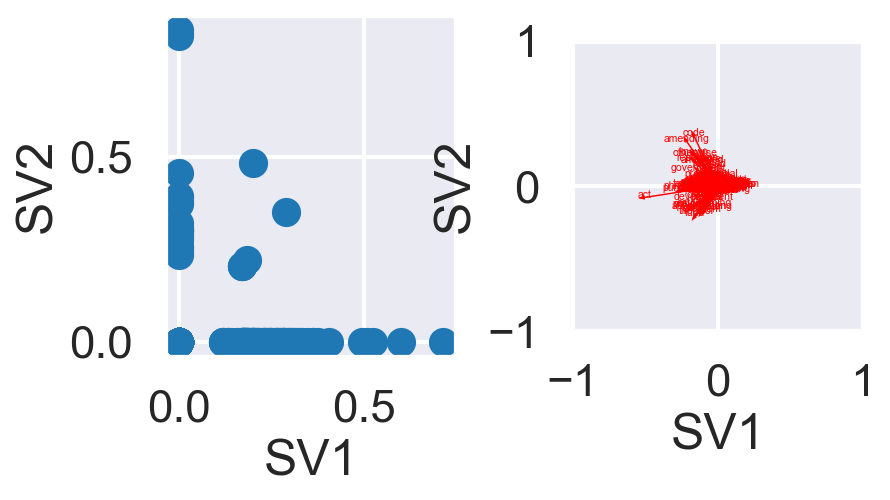

In [37]:
plot_svd(X, features, p)

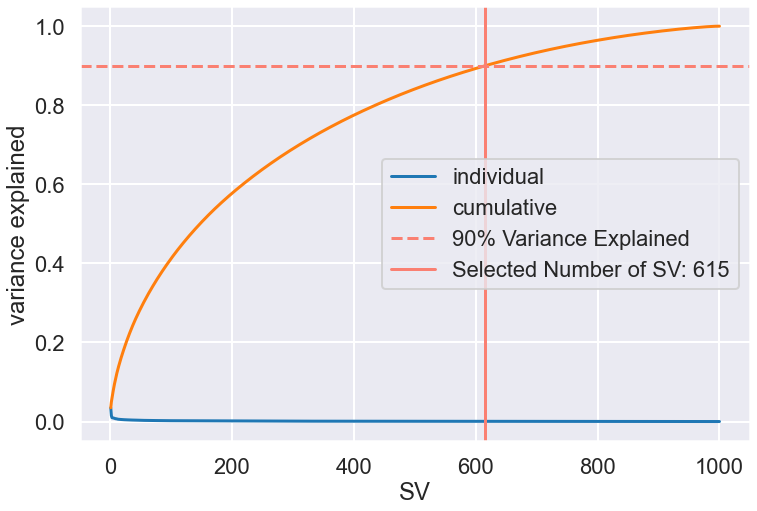

In [38]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(range(1, len(nssd)+1), nssd, '-', label='individual')
ax.plot(range(1, len(nssd)+1), nssd.cumsum(), '-', label='cumulative')
plt.axhline(0.9, linestyle='--', color='salmon')

chosen_sv = np.argwhere(nssd.cumsum() >= 0.9)[0][0]

plt.axvline(chosen_sv, color='salmon')

ax.legend(['individual', 'cumulative', '90% Variance Explained',
           f'Selected Number of SV: {chosen_sv}' ])
# ax.set_ylim(0, 1)

ax.set_xlabel('SV')

ax.set_ylabel('variance explained');

In [39]:
def project_svd(q, s, k):
    """Returns the projected result of SVD."""
    return q[:,:k].dot(s[:k,:k])

In [40]:
X_svd = project_svd(q, s, chosen_sv)
X_svd.shape

(15640, 615)

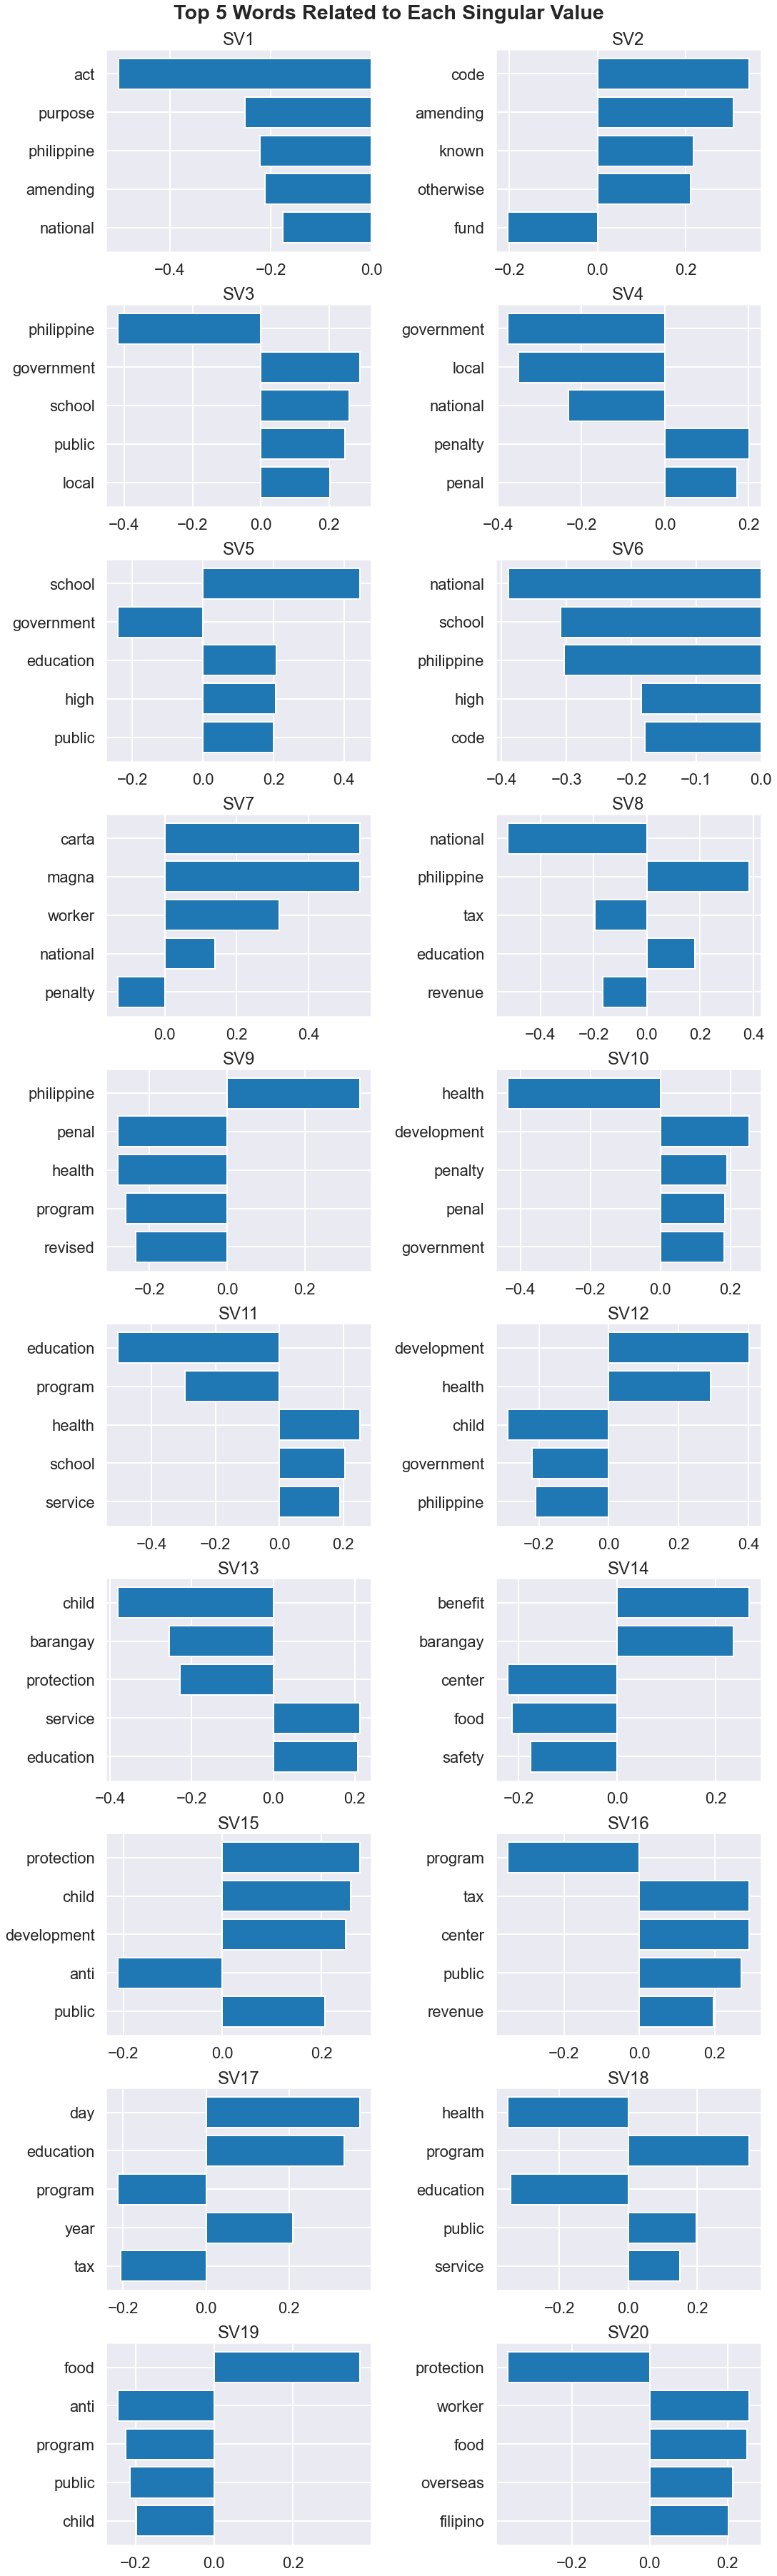

In [41]:
num_sv = 20
cols = 2
fig, axes = plt.subplots(int(num_sv/cols), cols, figsize=(15, 50),
                        constrained_layout=True)
axes = axes.ravel()

for i, ax in zip(range(0, num_sv), axes):
    sv_num = i+1
    order = np.argsort(np.abs(p[:, i]))[-5:]
    ax.barh([features[o] for o in order], p[order, i])
    ax.set_title(f'SV{sv_num}')
    
fig.suptitle("Top 5 Words Related to Each Singular Value",  
             fontweight="bold");

## Clustering

In [42]:
# from scipy.cluster.hierarchy import linkage, dendrogram
# Z = linkage(X_svd, method='ward', optimal_ordering=True)

In [43]:
# fig, ax = plt.subplots()
# dn = dendrogram(Z, ax=ax, p=20, truncate_mode='level', color_threshold=4.3)
# ax.axhline(4.3, linestyle='--', color='salmon')
# ax.set_xlabel('Samples')
# ax.set_title("Dendogram for Doing Agglomerative "
#              "Clustering with Ward's Method")
# ax.set_ylabel(r'$\Delta$');

In [44]:
# fig, ax = plt.subplots()
# dn = dendrogram(Z, ax=ax, p=20, truncate_mode='level', color_threshold=4.3)
# ax.axhline(4.3, linestyle='--', color='salmon')
# ax.set_xlabel('Samples')
# ax.set_title("Dendogram for Doing Agglomerative "
#              "Clustering with Ward's Method")
# ax.set_ylabel(r'$\Delta$');

In [45]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [46]:

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, 
                                linkage='ward')

model = model.fit(X_svd)

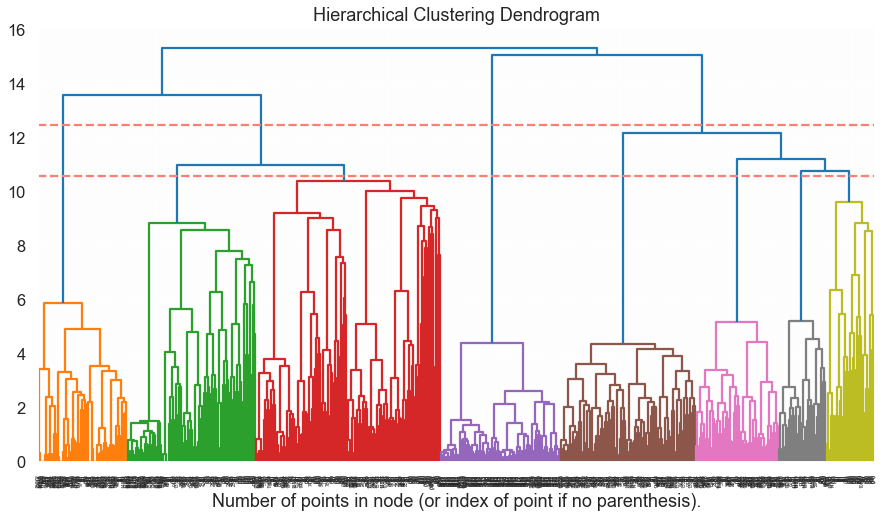

In [71]:
# plot the top three levels of the dendrogram
plt.figure(figsize=(15, 8))
plot_dendrogram(model, truncate_mode='level', p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.title('Hierarchical Clustering Dendrogram')
plt.axhline(10.6, color='salmon', linestyle='--')
plt.axhline(12.5, color='salmon', linestyle='--')
plt.show()

In [72]:
model1 = AgglomerativeClustering(distance_threshold=12.5, n_clusters=None, 
                                linkage='ward')

model2 = AgglomerativeClustering(distance_threshold=10.6, n_clusters=None, 
                                linkage='ward')

In [73]:
models = [model1, model2, model3]

for i, model in enumerate(models):
    df_clean[f'clustering_{i}'] = model.fit_predict(X_svd)

In [74]:
df_clean['clustering_1'].unique()

array([0, 7, 2, 6, 3, 1, 4, 5], dtype=int64)

In [75]:
df_clean['clustering_0'].unique()

array([1, 0, 3, 2], dtype=int64)

In [77]:
df_clean.to_pickle('clusters_added.pkl', protocol=3)